1. Perform any data preprocessing needed.

In [85]:
import pandas as pd
import string
import numpy as np
from collections import Counter
import re

# Step 1: Read the data from the CSV file
df = pd.read_csv('factuality_annotations_xsum_summaries.csv')

# We only need the summary and the label
df = df[['summary', 'is_factual']]

# dropping the columns with 'NULL' as the label
df = df[df['is_factual'].astype(str).str.strip().str.lower() != 'NULL']

# converting the yes and no as 1 and 0
df['is_factual'] = df['is_factual'].map({'no': 0, 'yes': 1})

# Dropping the NaN values
df = df.dropna(subset=['is_factual'])

# Convert to integers
df['is_factual'] = df['is_factual'].astype(int)

# Display few rows of the dataset
df.head(10)


<ipython-input-85-973ca732112d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_factual'] = df['is_factual'].astype(int)


,summary,is_factual
0,more than 50 pupils at a bristol academy have ...,0
1,more than 50 pupils at a bristol academy have ...,0
2,more than 50 pupils at a bristol academy have ...,0
3,the wife of a british-iranian woman jailed in ...,0
4,the wife of a british-iranian woman jailed in ...,0
5,the wife of a british-iranian woman jailed in ...,0
6,police searching for a greenock woman who has ...,0
7,police searching for a greenock woman who has ...,0
8,police searching for a greenock woman who has ...,0
9,aberdeen have appointed arbroath boss paul she...,1


In [86]:

# Step 4: Preprocessing function to clean the text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove extra whitespace
        text = ' '.join(text.split())
    return text

# Apply the preprocessing function to the summary column
df['summary'] = df['summary'].apply(preprocess_text)

# Step 6: Display the first few rows after preprocessing
print(df.head(25))
print(f"Remaining rows after cleaning: {len(df)}")


                                              summary  is_factual
0   more than 50 pupils at a bristol academy have ...           0
1   more than 50 pupils at a bristol academy have ...           0
2   more than 50 pupils at a bristol academy have ...           0
3   the wife of a britishiranian woman jailed in i...           0
4   the wife of a britishiranian woman jailed in i...           0
5   the wife of a britishiranian woman jailed in i...           0
6   police searching for a greenock woman who has ...           0
7   police searching for a greenock woman who has ...           0
8   police searching for a greenock woman who has ...           0
9   aberdeen have appointed arbroath boss paul she...           1
10  aberdeen have appointed arbroath boss paul she...           1
11  aberdeen have appointed arbroath boss paul she...           0
12  a sixyearold girl from cheshire who was given ...           0
13  a sixyearold girl from cheshire who was given ...           0
14  a sixy

2. Model Training: Implement Logistic Regression without any libraries, you must code the method we have studied in the class. Train the model using the training dataset and tune hyperparameters as necessary.

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Step 2: Extract features and labels
X = df['summary']
y = df['is_factual'].values

# Step 3: Compute TF-IDF for the entire corpus
def compute_tf_idf(corpus):
    tf = {}
    df = {}
    num_docs = len(corpus)

    # Calculate term frequency (TF) and document frequency (DF)
    for doc in corpus:
        words = doc.split()
        unique_words = set()
        for word in words:
            word = word.lower()
            if word not in tf:
                tf[word] = 0
            tf[word] += 1

            if word not in unique_words:
                unique_words.add(word)
                if word not in df:
                    df[word] = 0
                df[word] += 1

    # Calculate TF-IDF values
    tf_idf = {}
    for word, tf_value in tf.items():
        idf = np.log(num_docs / (df[word] + 1))  # +1 to prevent division by zero
        tf_idf[word] = tf_value * idf

    return tf_idf

# Step 4: Create feature matrix using the computed TF-IDF values
def create_feature_matrix(corpus, tf_idf_values):
    feature_matrix = []

    for doc in corpus:
        vector = []
        words = set(doc.split())
        for word in tf_idf_values.keys():
            word = word.lower()
            vector.append(tf_idf_values[word] if word in words else 0)
        feature_matrix.append(vector)

    return np.array(feature_matrix)

# Step 5: Compute TF-IDF for the entire dataset
tf_idf_values = compute_tf_idf(X)

# Step 6: Create the feature matrix
X_features = create_feature_matrix(X, tf_idf_values)

# Step 7: Split the dataset into training and testing sets
X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

# Step 8: Split the summaries to align with the test set
X_train_summaries, X_test_summaries = train_test_split(
    X, test_size=0.2, random_state=42, stratify=y
)

# Step 9: Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Step 10: Implement logistic regression
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)

        # Gradient descent
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights)
            y_predicted = sigmoid(linear_model)

            # Calculate gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))

            # Update weights
            self.weights -= self.learning_rate * dw

    def predict(self, X):
        linear_model = np.dot(X, self.weights)
        y_predicted = sigmoid(linear_model)
        y_classes = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_classes

# Step 11: Train the model
model = LogisticRegression(learning_rate=0.05, num_iterations=1000)
model.fit(X_train_features, y_train)

# Step 12: Make predictions on the testing set
predictions = model.predict(X_test_features)

# Step 13: Output the summaries and their predicted labels
print("\nPredicted Labels with Summaries:\n")
for summary, label in zip(X_test_summaries, predictions):
    print(f"Summary: {summary}\nPredicted Label: {label}\n")


<ipython-input-87-ec8e3ac93464>:72: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))



Predicted Labels with Summaries:

Summary: a byzantine gold coin found on a norwich gold coin has been discovered by a coroners challenge said
Predicted Label: 0

Summary: a pharmaceutical firm has announced plans to create more than 1000 jobs in newcastle with the loss of 260 jobs
Predicted Label: 0

Summary: work has started on a new £23m community hospital in somerset
Predicted Label: 0

Summary: the chief executive of barnet council has said he is disappointedby the councils decision to close the councils decision to leave the eu
Predicted Label: 0

Summary: greenock morton extended their lead at the top of the scottish league two table with victory over greenock morton
Predicted Label: 0

Summary: brain tumour patient ashya king has been diagnosed with cancer the bbc has learned
Predicted Label: 0

Summary: an optometrist accused of manslaughter and manslaughter contributed to the death of a 10yearold boy a
Predicted Label: 0

Summary: a woman has died following a fire at a house

<ipython-input-76-ec8e3ac93464>:72: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


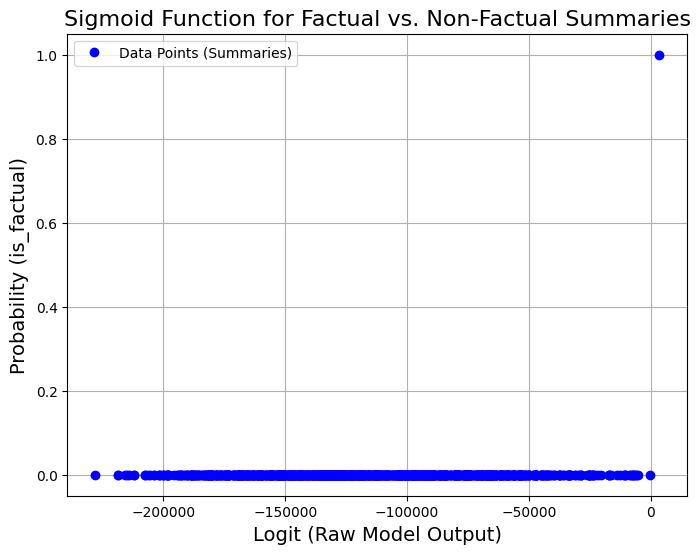

In [77]:
import matplotlib.pyplot as plt
logits = np.dot(X_test_features, model.weights)

# Step 3: Calculate probabilities using the sigmoid function
probabilities = sigmoid(logits)

# Step 4: Plot the sigmoid curve based on your dataset's predictions
plt.figure(figsize=(8, 6))
plt.plot(logits, probabilities, 'o', label='Data Points (Summaries)', markersize=6, color='blue')

# Step 5: Add labels and title
plt.xlabel('Logit (Raw Model Output)', fontsize=14)
plt.ylabel('Probability (is_factual)', fontsize=14)
plt.title('Sigmoid Function for Factual vs. Non-Factual Summaries', fontsize=16)

# Step 6: Add grid and legend
plt.grid(True)
plt.legend(loc='best')

# Step 7: Show the plot
plt.show()

Model Evaluation: Evaluate the model using appropriate metrics such as accuracy, precision, recall, and F1 score. Create a confusion matrix to visualize the model’s performance.

True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 996
False Negatives (FN): 116
Accuracy: 0.8949
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


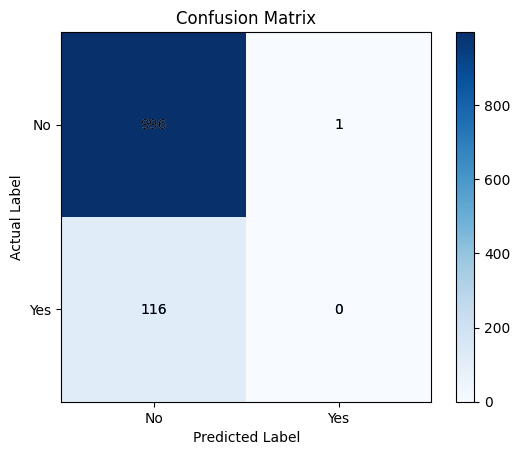

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 14: Create and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Extract TP, FP, TN, FN
TN, FP, FN, TP = conf_matrix.ravel()

# Function to calculate accuracy
def calculate_accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

# Function to calculate precision
def calculate_precision(TP, FP):
    return TP / (TP + FP) if (TP + FP) != 0 else 0

# Function to calculate recall
def calculate_recall(TP, FN):
    return TP / (TP + FN) if (TP + FN) != 0 else 0

# Function to calculate F1-score
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Calculate metrics
accuracy = calculate_accuracy(TP, TN, FP, FN)
precision = calculate_precision(TP, FP)
recall = calculate_recall(TP, FN)
f1_score = calculate_f1_score(precision, recall)


print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plotting the confusion matrix
labels = ['No', 'Yes']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")

# Annotate each cell with the numeric value
for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, value, ha='center', va='center', color='black')

plt.show()


4. Cross-Validation: Implement k-fold cross-validation to assess the model’s robustness. Report the average accuracy and standard deviation across the folds.

<ipython-input-87-ec8e3ac93464>:72: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Fold 1/5 Accuracy: 0.8831
Fold 2/5 Accuracy: 0.2860
Fold 3/5 Accuracy: 0.8957
Fold 4/5 Accuracy: 0.8921
Fold 5/5 Accuracy: 0.8799


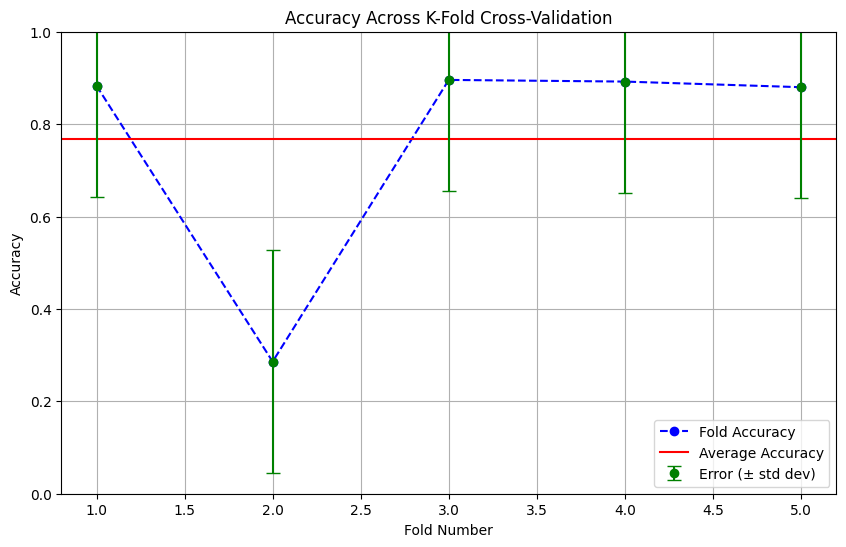


Average Accuracy: 0.7674, Standard Deviation: 0.2408


In [93]:
import numpy as np
import matplotlib.pyplot as plt

def k_fold_cross_validation(X, y, model_class, k=5, num_iterations=1000, learning_rate=0.01):
    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    X_shuffled = X[indices]
    y_shuffled = y[indices]

    fold_size = len(X) // k
    accuracies = []

    for fold in range(k):
        # Define the start and end of the validation fold
        start_val = fold * fold_size
        end_val = start_val + fold_size if fold != k - 1 else len(X)

        # Split the data into training and validation sets
        X_val = X_shuffled[start_val:end_val]
        y_val = y_shuffled[start_val:end_val]
        X_train = np.concatenate((X_shuffled[:start_val], X_shuffled[end_val:]), axis=0)
        y_train = np.concatenate((y_shuffled[:start_val], y_shuffled[end_val:]), axis=0)

        # Create and train the model
        model = model_class(learning_rate=learning_rate, num_iterations=num_iterations)
        model.fit(X_train, y_train)

        # Make predictions on the validation set
        predictions = model.predict(X_val)

        # Calculate accuracy for the current fold
        accuracy = np.mean(predictions == y_val)
        accuracies.append(accuracy)

        print(f"Fold {fold + 1}/{k} Accuracy: {accuracy:.4f}")

    # Calculate average accuracy and standard deviation across folds
    avg_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)

    # Plotting the Accuracy Scores Across Folds
    plt.figure(figsize=(10, 6))
    folds = range(1, k + 1)

    # Plot individual accuracies for each fold
    plt.plot(folds, accuracies, marker='o', linestyle='--', color='b', label='Fold Accuracy')

    # Plot the average accuracy as a horizontal line
    plt.axhline(y=avg_accuracy, color='r', linestyle='-', label='Average Accuracy')

    # Error bars using standard deviation
    plt.errorbar(folds, accuracies, yerr=std_dev, fmt='o', color='g', capsize=5, label='Error (± std dev)')

    # Set plot labels and title
    plt.title('Accuracy Across K-Fold Cross-Validation')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)

    # Show the plot
    plt.show()

    return avg_accuracy, std_dev


average_accuracy, std_deviation = k_fold_cross_validation(
    X_features, y, LogisticRegression, k=5, num_iterations=1000, learning_rate=0.01
)
print(f"\nAverage Accuracy: {average_accuracy:.4f}, Standard Deviation: {std_deviation:.4f}")


5. Error Analysis: Identify misclassified examples and analyze why the model failed on those instances. Suggest improvements based on your analysis.


In [97]:
misclassified_indices = np.where(predictions != y_test)[0]
print(f"Number of Misclassified Examples: {len(misclassified_indices)}\n")

# Displaying misclassified summaries
for i in misclassified_indices:
    print(f"Summary: {X_test_summaries.iloc[i]}")
    print(f"True Label: {y_test[i]}, Predicted Label: {predictions[i]}\n")


Number of Misclassified Examples: 117

Summary: brain tumour patient ashya king has been diagnosed with cancer the bbc has learned
True Label: 1, Predicted Label: 0

Summary: the us has urged china to end provocative waters in disputed waters in the south china sea
True Label: 1, Predicted Label: 0

Summary: a hospital trust is being investigated by the health watchdog over its finances
True Label: 1, Predicted Label: 0

Summary: the belfast giants came from behind to beat nottingham panthers 52 in the first of a elite league campaign
True Label: 1, Predicted Label: 0

Summary: cancer patients in denmark are being asked by gps to be diagnosed with cancer
True Label: 1, Predicted Label: 0

Summary: in india the indian state of goa was one of indias most iconic accumulation
True Label: 1, Predicted Label: 0

Summary: the conservatives have retained control of the green party in the wake of the 2009 vote in the european elections
True Label: 1, Predicted Label: 0

Summary: a former labour

The model failed on these instances because there was a class imbalance the class "no" is in majority hence the model is biased. This can be improved by using resampling techniques such as oversampling the minority class (e.g., using SMOTE) or undersampling the majority class to achieve a more balanced dataset. Additionally, adjusting class weights during model training can help the algorithm focus more on the minority class. Employing ensemble methods like Random Forest or Gradient Boosting can also enhance robustness to class imbalance. Furthermore, we can adjust the classification threshold to improve sensitivity for the minority class and utilize alternative evaluation metrics, such as F1-score and AUC-PR, to better assess performance.